In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class EarlyStopper:  # We define this class so that it performs the EarlyStopping check at each epoch
    def __init__(self, patience=1, min_delta=0, save_path="./best_model_with_label5_alfa09.pt"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss, model):
        """Returns whether the training should stop or not. If stopping criterion is not met returns False."""
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
def plot_history(history: dict, plot_list=[], scale="linear"):
    fig = plt.figure(figsize=(14, 7))
    plt.xlabel("Epoch")
    for plot in plot_list:
        plt.plot(history["epoch"], history[plot], label=plot)
    plt.yscale(scale)
    plt.legend(fontsize=30)
    plt.show()
def calculate_iou(y_true, y_pred, threshold=0.5):
    """
    Calcula el IoU entre las predicciones y las etiquetas reales.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
        
    Returns:
        float: Valor promedio de IoU.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    union = y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Evitar división por 0
    return iou.mean().item()
def calculate_dice(y_true, y_pred, threshold=0.5):
    """
    Calcula el coeficiente de Dice entre las predicciones y las etiquetas reales.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
        
    Returns:
        float: Valor promedio de Dice.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    intersection = (y_true * y_pred).sum(dim=(1, 2, 3))
    dice = (2 * intersection + 1e-6) / (y_true.sum(dim=(1, 2, 3)) + y_pred.sum(dim=(1, 2, 3)) + 1e-6)
    return dice.mean().item()
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calcula varias métricas en porcentaje para evaluar el modelo.
    """
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    TP = (y_pred * y_true).sum().item()  # Verdaderos positivos
    FP = (y_pred * (1 - y_true)).sum().item()  # Falsos positivos
    FN = ((1 - y_pred) * y_true).sum().item()  # Falsos negativos
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()  # Verdaderos negativos

    # Evitar divisiones por 0
    epsilon = 1e-6

    accuracy = ((TP + TN) / (TP + TN + FP + FN + epsilon)) * 100
    precision = (TP / (TP + FP + epsilon)) * 100
    recall = (TP / (TP + FN + epsilon)) * 100
    f1 = (2 * precision * recall / (precision + recall + epsilon))
    iou = (TP / (TP + FP + FN + epsilon)) * 100

    return {
        "Accuracy (%)": accuracy,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1,
        "IoU (%)": iou
    }

def train_model(model,
                train_dataloader=None,
                val_dataloader=None,
                lr=None,
                optimizer=None,
                epochs=None,
                early_stopper=None):
    history = {"loss": [], "val_loss": [], "epoch": []}
    optimizer = optimizer(model.parameters(), lr=lr)
    scaler = GradScaler('cuda')  # Inicializar el escalador de gradientes

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for data in train_dataloader:
            inputs, (segmentation_targets, classification_targets) = data[0].to(DEVICE), \
                                                             (data[1][0].to(DEVICE), data[1][1].to(DEVICE).unsqueeze(1))

            optimizer.zero_grad()

            # Usar autocast para operaciones de precisión mixta
            with autocast('cuda'):
                segmentation_outputs, classification_outputs = model(inputs)
                loss = combined_loss(segmentation_outputs, segmentation_targets,
                                     classification_outputs, classification_targets)

            # Escalar la pérdida y retropropagar
            scaler.scale(loss).backward()

            # Escalar el optimizador para actualizar los parámetros
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_dataloader)
        history["loss"].append(avg_loss)

        # Validación
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for vdata in val_dataloader:
                vinputs, (vsegmentation_targets, vclassification_targets) = vdata[0].to(DEVICE), \
                                                                             (vdata[1][0].to(DEVICE), vdata[1][1].to(DEVICE))
                with autocast('cuda'):
                    vsegmentation_outputs, vclassification_outputs = model(vinputs)
                    vloss = combined_loss(vsegmentation_outputs, vsegmentation_targets,
                                          vclassification_outputs, vclassification_targets)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / len(val_dataloader)
        history["val_loss"].append(avg_vloss)

        # Early stopping
        if early_stopper and early_stopper.early_stop(avg_vloss, model):
            break

        print(f"Epoch {epoch + 1}: Train Loss = {avg_loss:.4f}, Validation Loss = {avg_vloss:.4f}")

    return history


def load_dataset(root_dir):
    """
    Carga todas las imágenes, etiquetas de segmentación y etiquetas de clasificación.
    
    Args:
        root_dir (str): Ruta de la carpeta raíz que contiene las carpetas kosXX.

    Returns:
        images (list): Lista de arrays de imágenes.
        segmentation_labels (list): Lista de arrays de etiquetas de segmentación.
        classification_labels (list): Lista de etiquetas de clasificación (OK/NOK).
    """
    images = []
    segmentation_labels = []
    classification_labels = []
    images_augmented = []
    segmentation_labels_augmented = []
    classification_labels_augmented = []

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)

        if os.path.isdir(folder_path):
            for file in sorted(os.listdir(folder_path)):
                file_path = os.path.join(folder_path, file)

                if file.endswith(".jpg"):  # Imágenes
                    img = Image.open(file_path).convert("L")
                    img_array = np.array(img) / 255.0  # Normalizar a [0, 1]
                    if "aug" in file:  # Datos aumentados
                        images_augmented.append(img_array)
                    else:
                        images.append(img_array)

                elif file.endswith(".bmp"):  # Mapas de bits (segmentación)
                    label = Image.open(file_path).convert("L")
                    label_array = np.array(label) / 255.0  # Normalizar a [0, 1]
                    classification_label = 1 if np.sum(label_array) > 0 else 0  # OK = 0, NOK = 1
                    if "aug" in file:  # Datos aumentados
                        segmentation_labels_augmented.append(label_array)
                        classification_labels_augmented.append(classification_label)
                    else:
                        segmentation_labels.append(label_array)
                        classification_labels.append(classification_label)

    return (images, segmentation_labels, classification_labels,
            images_augmented, segmentation_labels_augmented, classification_labels_augmented)


In [5]:
# Ruta de la carpeta raíz
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Imagenes_defectos"
(images, segmentation_labels, classification_labels,
 images_augmented, segmentation_labels_augmented, classification_labels_augmented) = load_dataset(root_dir)

# Imprimir información del dataset
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas de segmentacion cargadas: {len(segmentation_labels)}")
print(f"Número de etiquetas de clasificacion cargadas: {len(classification_labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas de segmentacion augmented cargadas: {len(segmentation_labels_augmented)}")
print(f"Número de etiquetas de clasificacion augmented cargadas: {len(classification_labels_augmented)}")
# Agregar datos aumentados
images += images_augmented
segmentation_labels += segmentation_labels_augmented
classification_labels += classification_labels_augmented

# Normalizar imágenes y etiquetas
images = [img for img in images]
segmentation_labels = [label for label in segmentation_labels]

# Dividir en conjuntos de entrenamiento, validación y prueba
train_images, test_images, train_seg_labels, test_seg_labels, train_class_labels, test_class_labels = train_test_split(
    images, segmentation_labels, classification_labels, test_size=0.2, random_state=40
)

val_images, test_images, val_seg_labels, test_seg_labels, val_class_labels, test_class_labels = train_test_split(
    test_images, test_seg_labels, test_class_labels, test_size=0.5, random_state=40
)
from torchvision import transforms

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])

# Transformaciones para las etiquetas
label_transform = transforms.Compose([
    transforms.Resize((1024, 512)),
    transforms.ToTensor(),  # Convertir a tensor
])

Número de imágenes cargadas: 399
Número de etiquetas de segmentacion cargadas: 399
Número de etiquetas de clasificacion cargadas: 399
Número de imágenes augmented cargadas: 280
Número de etiquetas de segmentacion augmented cargadas: 280
Número de etiquetas de clasificacion augmented cargadas: 280


In [6]:
class CustomDataset(Dataset):
    def __init__(self, images, segmentation_labels, classification_labels, transform=None, label_transform=None):
        self.images = images
        self.segmentation_labels = segmentation_labels
        self.classification_labels = classification_labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        segmentation_label = Image.fromarray(self.segmentation_labels[idx])
        classification_label = torch.tensor(self.classification_labels[idx], dtype=torch.float32).unsqueeze(0)  # Agregar dimensión
    
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            segmentation_label = self.label_transform(segmentation_label)
    
        return image, (segmentation_label, classification_label)



# Crear datasets
train_dataset = CustomDataset(
    images=train_images,
    segmentation_labels=train_seg_labels,
    classification_labels=train_class_labels,
    transform=transform,
    label_transform=label_transform
)

val_dataset = CustomDataset(
    images=val_images,
    segmentation_labels=val_seg_labels,
    classification_labels=val_class_labels,
    transform=transform,
    label_transform=label_transform
)

test_dataset = CustomDataset(
    images=test_images,
    segmentation_labels=test_seg_labels,
    classification_labels=test_class_labels,
    transform=transform,
    label_transform=label_transform
)

def depthwise_separable_conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=1)
    )


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        self.bottleneck = self.conv_block(128, 256)

        # Branch 1: Mapas de bits (Segmentación)
        self.up4 = self.upconv(256, 128)
        self.dec4 = self.conv_block(256, 128)  # Ajustado
        self.up3 = self.upconv(128, 64)
        self.dec3 = self.conv_block(128, 64)  # Ajustado
        self.up2 = self.upconv(64, 32)
        self.dec2 = self.conv_block(64, 32)  # Ajustado
        self.up1 = self.upconv(32, 16)
        self.dec1 = self.conv_block(32, 16)  # Ajustado
        self.final_segmentation = nn.Conv2d(16, out_channels, kernel_size=1)

        # Branch 2: Clasificación binaria (OK/NOK)
        self.classification_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Branch 1: Mapas de bits (Segmentación)
        dec4 = self.up4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        segmentation_output = self.final_segmentation(dec1)

        # Branch 2: Clasificación
        classification_output = self.classification_head(bottleneck)

        return segmentation_output, classification_output





In [7]:
# Calcular el peso de la clase positiva para la clasificación binaria
num_positivos = sum(train_class_labels)  # Número de etiquetas NOK (1)
num_negativos = len(train_class_labels) - num_positivos  # Número de etiquetas OK (0)
pos_weight = torch.tensor([num_negativos / num_positivos], dtype=torch.float32).to(DEVICE)

# Calcular pesos para el muestreador
class_counts = [num_negativos, num_positivos]  # Conteo de clases [OK, NOK]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)  # Pesos inversos
sample_weights = [class_weights[1] if label == 1 else class_weights[0] for label in train_class_labels]

# Crear un sampler ponderado
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


# Función de pérdida y optimizador
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  # Probabilidad predicha
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# criterion = FocalLoss(alpha=0.25, gamma=2) #
def combined_loss(segmentation_output, segmentation_target, classification_output, classification_target, alpha=0.9):
    # Asegurar dimensiones correctas para clasificación
    classification_target = classification_target.view(-1, 1)
    
    # Pérdida para la segmentación
    segmentation_loss = nn.BCEWithLogitsLoss()(segmentation_output, segmentation_target)
    
    # Pérdida para la clasificación
    classification_loss = nn.BCEWithLogitsLoss()(classification_output, classification_target)
    
    # Pérdida combinada
    total_loss = alpha * segmentation_loss + (1 - alpha) * classification_loss
    return total_loss



# Crear DataLoader con el sampler
batch_size = 15
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instanciar el modelo
model = UNet(in_channels=1, out_channels=1).to(DEVICE)

# Configurar los parámetros de entrenamiento
learning_rate = 1e-4
optimizer = optim.Adam
epochs = 25

# Instanciar Early Stopper
early_stopper = EarlyStopper(patience=5, min_delta=0.005)

In [158]:

# Llamar a la función de entrenamiento
history = train_model(
    model=model,
    train_dataloader=train_loader,  # DataLoader del conjunto de entrenamiento
    val_dataloader=val_loader,      # DataLoader del conjunto de validación
    lr=learning_rate,               # Tasa de aprendizaje
    optimizer=optimizer,            # Optimizador
    epochs=epochs,                  # Número de épocas
    early_stopper=early_stopper     # Early stopping
)

Epoch 1: Train Loss = 0.7775, Validation Loss = 0.7728
Epoch 2: Train Loss = 0.7647, Validation Loss = 0.7424
Epoch 3: Train Loss = 0.2753, Validation Loss = 0.0938
Epoch 4: Train Loss = 0.0907, Validation Loss = 0.0867
Epoch 5: Train Loss = 0.0886, Validation Loss = 0.0865
Epoch 6: Train Loss = 0.0868, Validation Loss = 0.0827
Epoch 7: Train Loss = 0.0857, Validation Loss = 0.0829
Epoch 8: Train Loss = 0.0848, Validation Loss = 0.0820
Epoch 9: Train Loss = 0.0846, Validation Loss = 0.0818
Epoch 10: Train Loss = 0.0846, Validation Loss = 0.0821
Epoch 11: Train Loss = 0.0843, Validation Loss = 0.0825
Epoch 12: Train Loss = 0.0830, Validation Loss = 0.0798
Epoch 13: Train Loss = 0.0806, Validation Loss = 0.0776
Epoch 14: Train Loss = 0.0793, Validation Loss = 0.0766
Epoch 15: Train Loss = 0.0770, Validation Loss = 0.0740
Epoch 16: Train Loss = 0.0775, Validation Loss = 0.0753
Epoch 17: Train Loss = 0.0765, Validation Loss = 0.0746
Epoch 18: Train Loss = 0.0759, Validation Loss = 0.0728
E

In [159]:
print(history.keys())
print(history)
def plot_history(history, plot_list, scale="linear"):
    import matplotlib.pyplot as plt
    
    epochs = range(len(history["loss"]))  # Ajuste aquí
    plt.figure(figsize=(14, 7))
    plt.xlabel("Epoch")
    
    for plot in plot_list:
        plt.plot(epochs, history[plot], label=plot)  # Usar epochs en lugar de history["epoch"]
    
    plt.yscale(scale)
    plt.legend(fontsize=12)
    plt.show()


dict_keys(['loss', 'val_loss', 'epoch'])
{'loss': [0.7774938425502261, 0.764703589516717, 0.2753412967195382, 0.09071036649716867, 0.08860254750863926, 0.08680171720884941, 0.08566141329907082, 0.08481587771628354, 0.08459767920745385, 0.08458788612404385, 0.0842834421106287, 0.08302157895790564, 0.08062276747581121, 0.07933381260246844, 0.07699363416916616, 0.07754626185507388, 0.07646396272891276, 0.07590269740368868, 0.0765210972041697, 0.07464155514498015, 0.07486058892430486, 0.07017708448944865, 0.09890497818186476, 0.07807679313260156, 0.07495524532891609], 'val_loss': [0.7728356003761292, 0.7424239635467529, 0.093843474984169, 0.08673645108938217, 0.08654553890228271, 0.08272184133529663, 0.08286838084459305, 0.08195078372955322, 0.08183320462703705, 0.0820809930562973, 0.0824620246887207, 0.07980061024427414, 0.07755107432603836, 0.07655419260263444, 0.07398300319910049, 0.07525768280029296, 0.07458753734827042, 0.0727682277560234, 0.07452219128608703, 0.07127867341041565, 0.0

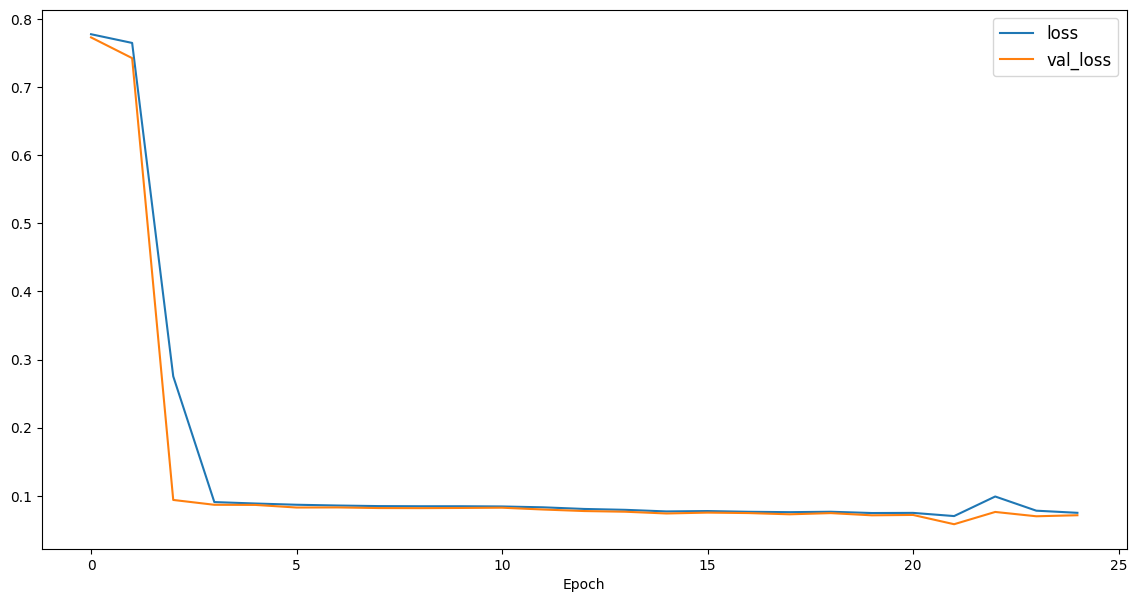

In [160]:
# Visualizar la evolución de la pérdida
plot_history(history, plot_list=["loss", "val_loss"])

Número de imágenes cargadas: 16
Número de etiquetas de segmentacion cargadas: 16
Número de etiquetas de clasificacion cargadas: 16
Número de imágenes augmented cargadas: 0
Número de etiquetas de segmentacion augmented cargadas: 0
Número de etiquetas de clasificacion augmented cargadas: 0


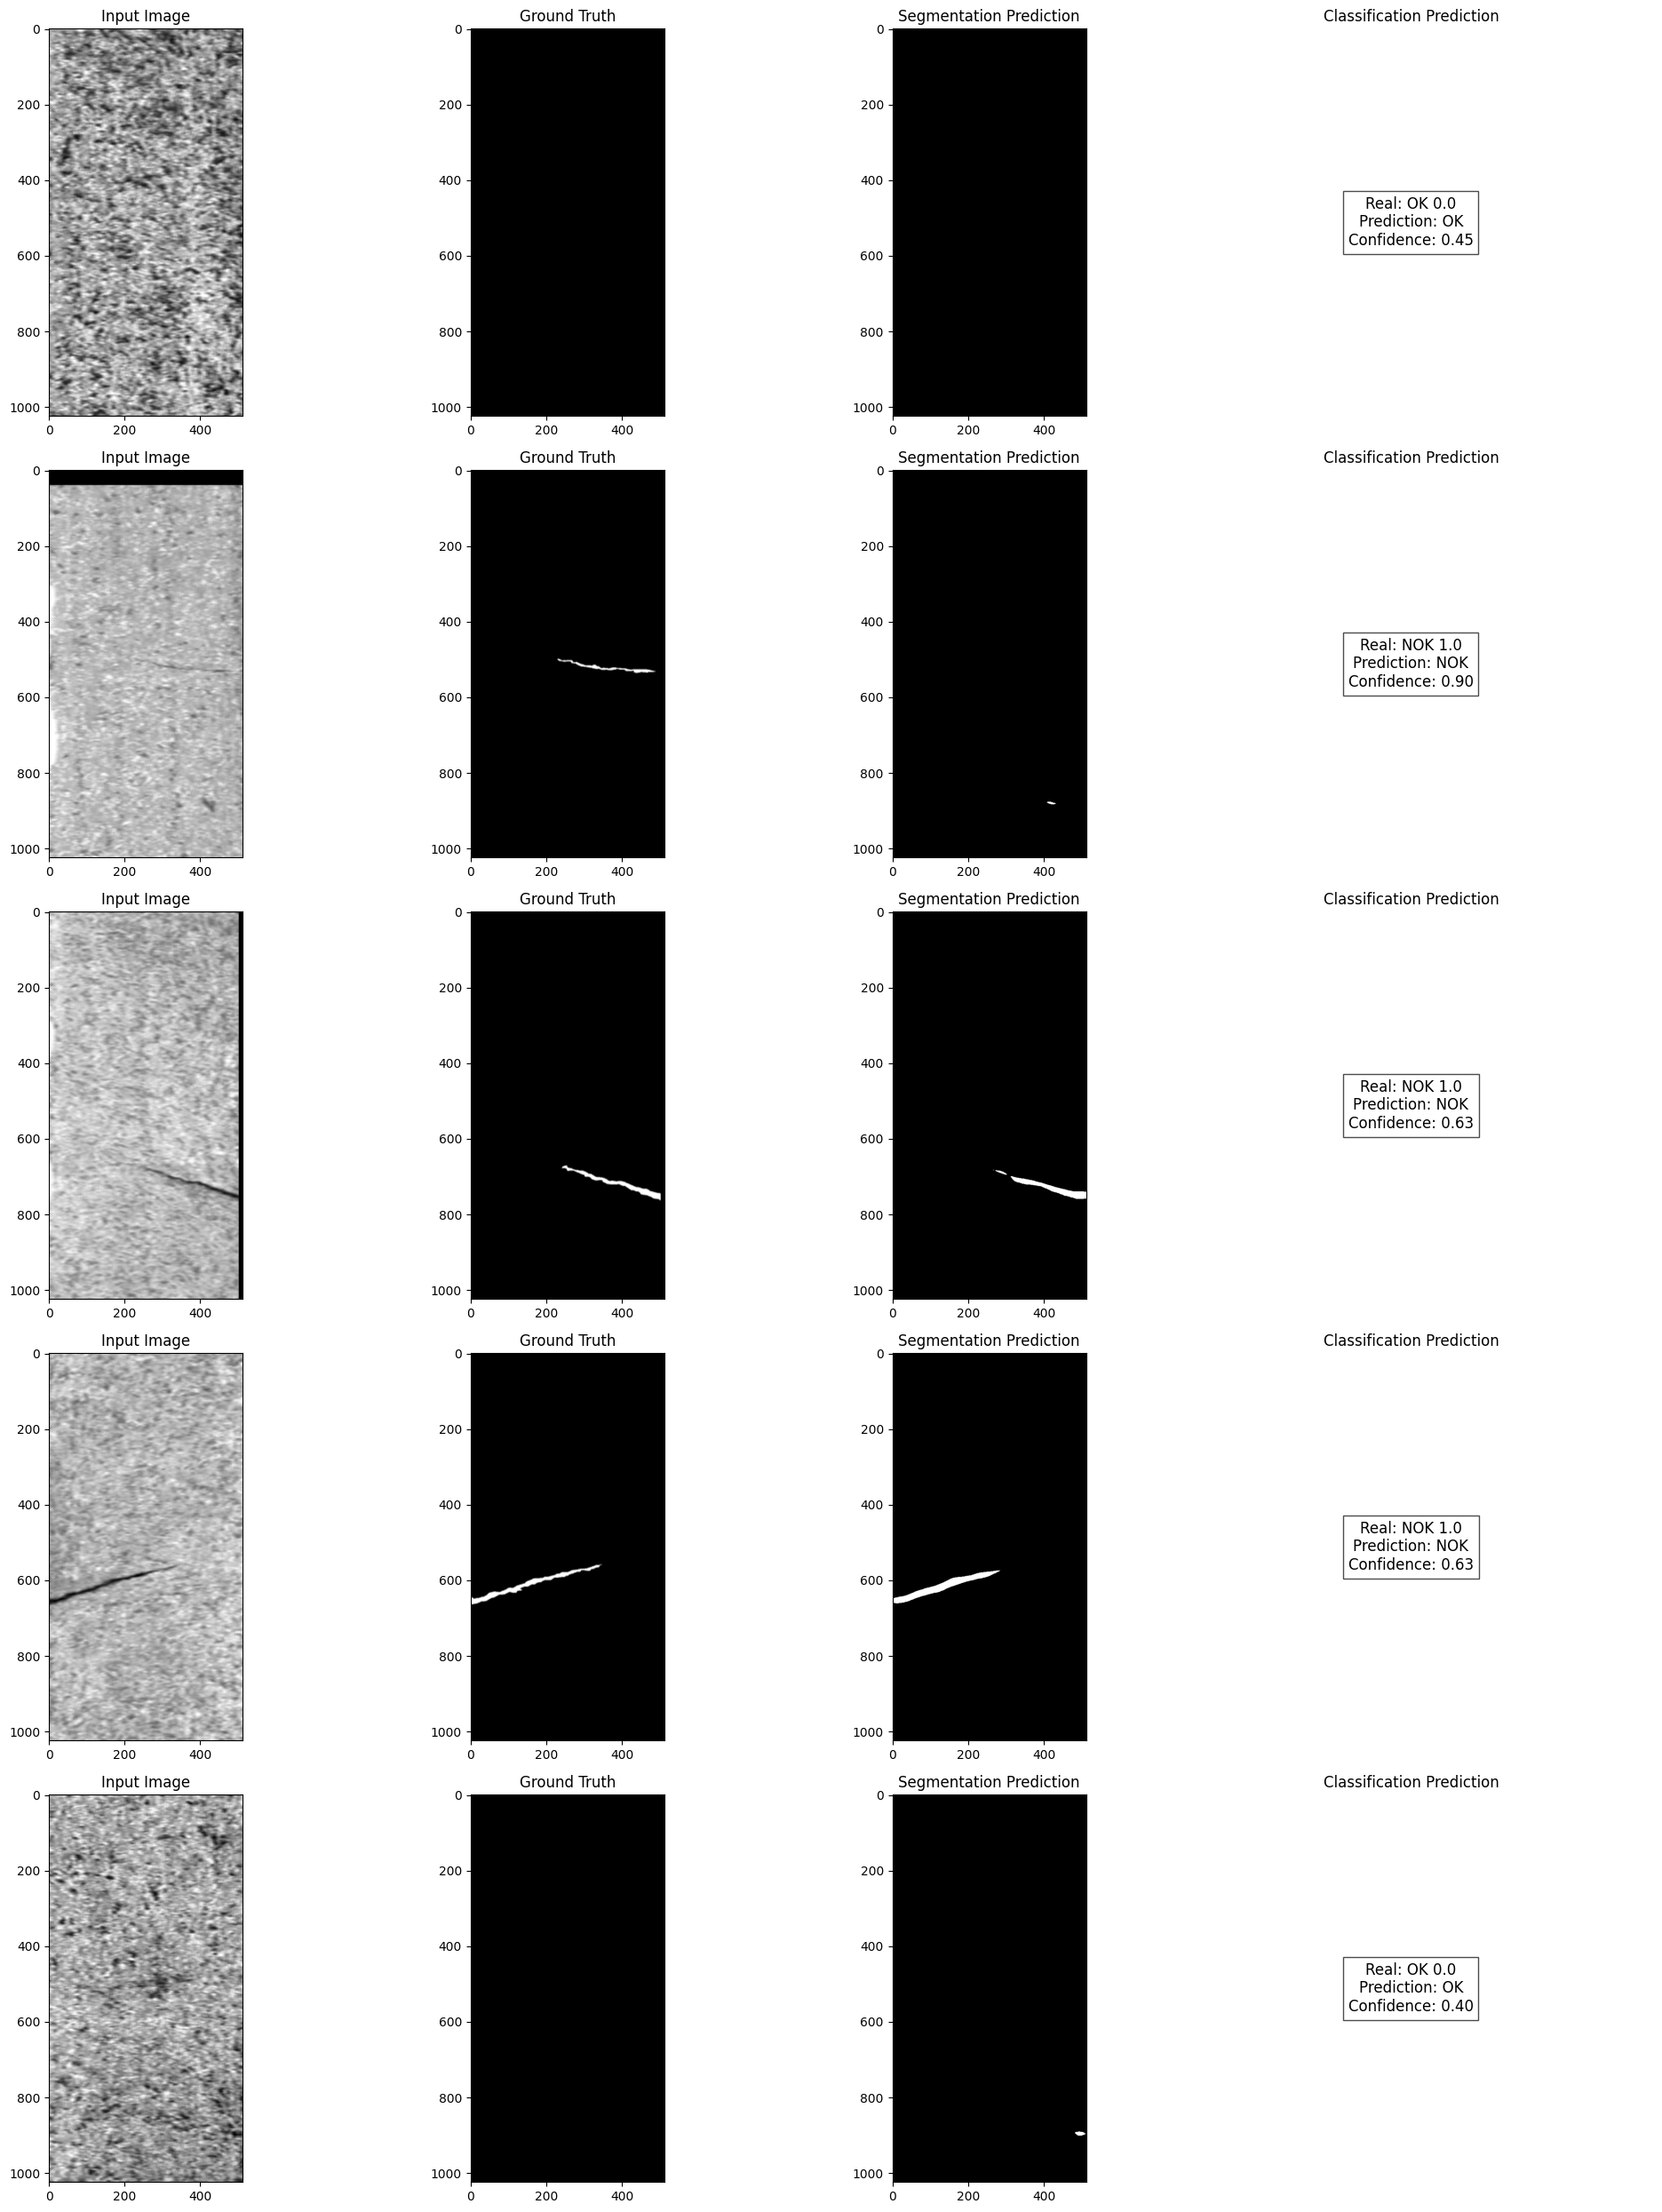

In [10]:
def visualize_predictions(model, data_loader, num_samples=3, threshold=0.01):
    """
    Visualiza las imágenes, etiquetas reales y predicciones del modelo.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        data_loader (DataLoader): DataLoader con las imágenes y etiquetas.
        num_samples (int): Número de muestras a visualizar.
        threshold (float): Umbral para binarizar las predicciones.
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    for i, (image, (segmentation_label, classification_label)) in enumerate(data_loader):
        if i >= num_samples:
            break

        with torch.no_grad():
            segmentation_pred, classification_pred = model(image.to(DEVICE))
            segmentation_pred = torch.sigmoid(segmentation_pred).cpu()  # Aplicar Sigmoid
            segmentation_pred = (segmentation_pred > threshold).float()  # Binarizar las predicciones

            classification_pred = torch.sigmoid(classification_pred).cpu().numpy()  # Aplicar Sigmoid
            classification_pred_label = (classification_pred > 0.45).astype(int)  # Binarizar predicción

        # Convertir tensores a arrays NumPy
        image_np = image[0].squeeze().cpu().numpy()
        segmentation_label_np = segmentation_label[0].squeeze().cpu().numpy()
        segmentation_pred_np = segmentation_pred[0].squeeze().cpu().numpy()

        # Mostrar imágenes, etiquetas y predicciones
        axes[i, 0].imshow(image_np, cmap='gray')
        axes[i, 0].set_title('Input Image')
        
        axes[i, 1].imshow(segmentation_label_np, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        
        axes[i, 2].imshow(segmentation_pred_np, cmap='gray')
        axes[i, 2].set_title('Segmentation Prediction')
        
        axes[i, 3].text(
            0.5, 0.5, 
            f'Real: {"NOK" if classification_label[0][0] else "OK"} {classification_label[0][0]}\nPrediction: {"NOK" if classification_pred_label[0][0] else "OK"}\nConfidence: {classification_pred[0][0]:.2f}',
            fontsize=12, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7)
        )
        axes[i, 3].set_title('Classification Prediction')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()
root_dir = r"C:\Users\jerij\Carpetas\Clases Formaciones Curro\Master\2Semestre\Proyecto\Data\Pruebas"  
(images, segmentation_labels, classification_labels,
 images_augmented, segmentation_labels_augmented, classification_labels_augmented) = load_dataset(root_dir)
# Imprimir información del dataset
print(f"Número de imágenes cargadas: {len(images)}")
print(f"Número de etiquetas de segmentacion cargadas: {len(segmentation_labels)}")
print(f"Número de etiquetas de clasificacion cargadas: {len(classification_labels)}")
print(f"Número de imágenes augmented cargadas: {len(images_augmented)}")
print(f"Número de etiquetas de segmentacion augmented cargadas: {len(segmentation_labels_augmented)}")
print(f"Número de etiquetas de clasificacion augmented cargadas: {len(classification_labels_augmented)}")
images = [img / 255.0 for img in images]
labels = [label / 255.0 for label in segmentation_labels]
evaluacion_dataset = CustomDataset(
    images=images,
    segmentation_labels=labels,
    classification_labels=classification_labels,
    transform=transform,
    label_transform=label_transform
)

evaluacion_loader = DataLoader(evaluacion_dataset, batch_size=1, shuffle=True)
visualize_predictions(model, test_loader, num_samples=5, threshold=0.5)

In [164]:
def calculate_metrics(y_true, y_pred, threshold=0.5):
    """
    Calcula varias métricas en porcentaje para evaluar el modelo.
    
    Args:
        y_true (torch.Tensor): Tensor de etiquetas reales.
        y_pred (torch.Tensor): Tensor de predicciones del modelo.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas en porcentaje.
    """
    y_pred = (y_pred > threshold).float()  # Binarizar predicciones
    y_true = y_true.float()  # Asegurar que las etiquetas sean float

    # Calcular métricas básicas
    TP = (y_pred * y_true).sum().item()  # Verdaderos positivos
    FP = (y_pred * (1 - y_true)).sum().item()  # Falsos positivos
    FN = ((1 - y_pred) * y_true).sum().item()  # Falsos negativos
    TN = ((1 - y_pred) * (1 - y_true)).sum().item()  # Verdaderos negativos

    # Evitar divisiones por 0
    epsilon = 1e-6

    # Métricas
    accuracy = ((TP + TN) / (TP + TN + FP + FN + epsilon)) * 100
    precision = (TP / (TP + FP + epsilon)) * 100
    recall = (TP / (TP + FN + epsilon)) * 100
    f1 = (2 * precision * recall / (precision + recall + epsilon))
    iou = (TP / (TP + FP + FN + epsilon)) * 100

    return {
        "Accuracy (%)": accuracy,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1,
        "IoU (%)": iou
    }

def evaluate_model(model, test_loader, threshold=0.5):
    """
    Evalúa el modelo en el conjunto de prueba y calcula métricas promedio.
    
    Args:
        model (torch.nn.Module): Modelo entrenado.
        test_loader (DataLoader): DataLoader del conjunto de prueba.
        threshold (float): Umbral para binarizar las predicciones.
    
    Returns:
        dict: Diccionario con las métricas promedio en porcentaje.
    """
    model.eval()
    all_metrics = {
        "Accuracy (%)": [],
        "Precision (%)": [],
        "Recall (%)": [],
        "F1-Score (%)": [],
        "IoU (%)": []
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = torch.sigmoid(model(images))  # Aplicar Sigmoid

            # Calcular métricas para cada batch
            metrics = calculate_metrics(labels, outputs, threshold)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])

    # Promediar las métricas
    averaged_metrics = {key: np.mean(values) for key, values in all_metrics.items()}
    return averaged_metrics

# Evaluar el modelo
metrics = evaluate_model(model, test_loader, threshold=0.5)

# Mostrar resultados
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}%")

AttributeError: 'list' object has no attribute 'to'